# Preprocesamiento

## Importamos librerias

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score

## Cargamos las imagenes

In [2]:
# Specify the parent path where the the 'masked' and 'original' pictures are.

rootpath = "faces/"
files_non_smile = os.listdir(rootpath + "non_smile/")

files_smile = os.listdir(rootpath + "smile/")


n_non_smile = len(files_non_smile)
n_smile = len(files_smile)

target_size = (200,200) # Image size. For computational reasons, resize the images to 200x200

imgs_non_smile = [] # Original images are stored here.

imgs_smile = [] # Images with mask are stored here.

for i in range(n_non_smile):
    img = image.load_img(rootpath + "non_smile/" + files_non_smile[i], target_size=target_size)
    img = image.img_to_array(img)
    img = img/255.
    imgs_non_smile.append(img)

for i in range(n_smile):
    img2 = image.load_img(rootpath + "smile/" + files_smile[i], target_size=target_size)
    img2 = image.img_to_array(img2)
    img2 = img2/255.
    imgs_smile.append(img2)

imgs_non_smile=np.array(imgs_non_smile)

imgs_smile=np.array(imgs_smile)

# shuffle images
n_non_smile = imgs_non_smile.shape[0]
n_smile = imgs_smile.shape[0]
np.random.seed(123)
idxs_ns = np.random.choice(n_non_smile, size=n_non_smile, replace=False)
idxs_s = np.random.choice(n_smile, size=n_smile, replace=False)
imgs_non_smile = imgs_non_smile[idxs_ns,:,:,:]
imgs_smile = imgs_smile[idxs_s,:,:,:]

## Imprimimos una imagen

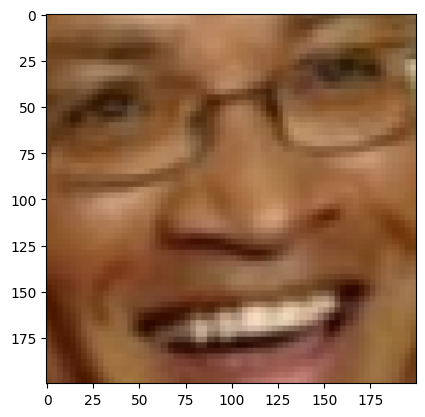

In [12]:
selected = 17
plt.imshow(imgs_smile[selected,])

## Division de los conjuntos en prueba y entrenamiento

In [5]:
train_features, test_features = train_test_split(imgs_non_smile, train_size = 0.80, random_state = 37)
train_features_s, test_features_s = train_test_split(imgs_smile, train_size = 0.80, random_state = 37)

In [6]:
test_features_mix = np.concatenate((test_features, test_features_s), axis=0)
train_features_mix = np.concatenate((train_features, train_features_s), axis=0)

In [7]:
train_labels = np.concatenate((np.zeros(len(train_features)), np.ones(len(train_features_s))), axis=0)
test_labels = np.concatenate((np.zeros(len(test_features)), np.ones(len(test_features_s))), axis=0)

# Autoencoder

In [15]:
input_img = Input(shape=(200, 200, 3))

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='linear', padding='same')(x)

autoencoder = Model(input_img, decoded)

opt = optimizers.Adam()

autoencoder.compile(optimizer=opt, loss='mse')

print(autoencoder.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 200, 200, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 200, 200, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 100, 100, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 200, 200, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 200, 200, 3)    │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,915 (784.82 KB)

 Trainable params: 200,915 (784.82 KB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model.
history = autoencoder.fit(train_features, train_features,
                epochs=100,
                batch_size=20,
                shuffle=True,
                validation_split=0.15,
                callbacks=[early_stopping])

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.1526 - val_loss: 0.0185
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - loss: 0.0175 - val_loss: 0.0093
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - loss: 0.0084 - val_loss: 0.0047
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.0048 - val_loss: 0.0038
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.0039 - val_loss: 0.0034
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 0.0034 - val_loss: 0.0029
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.0028 - val_loss: 0.0024
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 0.0020 - val_loss: 0.0014
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 0.0011 - val_loss: 9.1239e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 0.0010 - val_loss: 8.4069e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - l

In [17]:
test_predictions = autoencoder.predict(test_features_mix)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 771ms/step


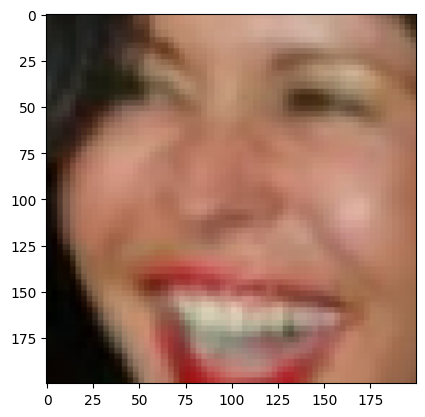

In [30]:
plt.imshow(test_features_mix[-1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 650ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013888268..0.8877801].


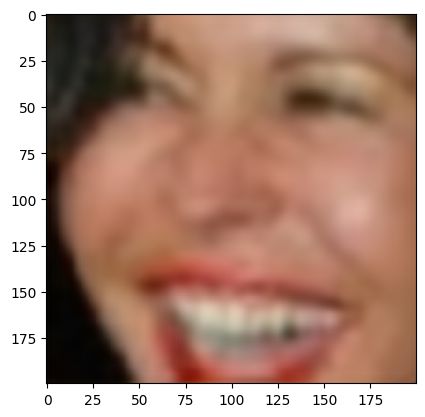

In [29]:
plt.imshow(autoencoder.predict(test_features_mix)[-1])

In [18]:
def squared_errors(predictions, targets):
	return np.sum((predictions - targets) ** 2, axis=(1, 2, 3))

test_squared_errors = squared_errors(test_predictions, test_features_mix)

In [19]:
threshold = 0.05
test_predictions = np.where(np.array(test_squared_errors) > threshold, 0, 1)

In [20]:
accuracy = accuracy_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

Accuracy: 0.5020746887966805
Recall: 0.0


El autoencoder no tiene un buen desempeño debido a que reconstruye bien las imagenes dadas, por lo que les haremos un preprocesado para extraer sus bordes con open-cv

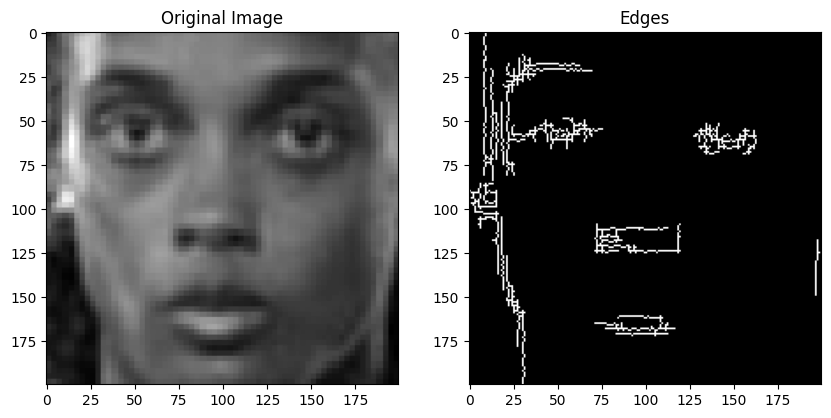

In [53]:
import cv2

image = cv2.cvtColor(test_features_mix[1], cv2.COLOR_RGB2GRAY)
image_8bit = cv2.convertScaleAbs(image, alpha=(255.0))
blurred_image = cv2.GaussianBlur(image_8bit, (3, 3), 0.5)
edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Edges')
plt.imshow(edges, cmap='gray')

plt.show()

## Preprocesamiento de imagenes

In [85]:
edges_list_mixed = []

for img in test_features_mix:
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    image_8bit = cv2.convertScaleAbs(image, alpha=(255.0))
    blurred_image = cv2.GaussianBlur(image_8bit, (3, 3), 0.5)
    edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)
    edges_list_mixed.append(edges)

edges_array_mixed = np.array(edges_list_mixed)
print(edges_array_mixed.shape)

(241, 200, 200)


In [86]:
edges_list_train = []

for img in train_features:
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    image_8bit = cv2.convertScaleAbs(image, alpha=(255.0))
    blurred_image = cv2.GaussianBlur(image_8bit, (3, 3), 0.5)
    edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)
    edges_list_train.append(edges)

edges_array_train = np.array(edges_list_train)
print(edges_array_train.shape)

(482, 200, 200)


In [ ]:
for img in edges_list_train:
    img[img == 255] = 1

for img in edges_list_mixed:
    img[img == 255] = 1

In [110]:
import tensorflow as tf


def weighted_mse(y_true, y_pred):
    weights = tf.where(y_true == 1, 0.98, 0.02)
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

input_img = Input(shape=(200, 200, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder_2 = Model(input_img, decoded)

opt = optimizers.Adam()

autoencoder_2.compile(optimizer=opt, loss=weighted_mse)

print(autoencoder_2.summary())

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 200, 200, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_24 (UpSampling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_25 (UpSampling2D) │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 200, 200, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,425 (185.25 KB)

 Trainable params: 47,425 (185.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [108]:
edges_array_train = np.array(edges_list_train).reshape(-1, 200, 200, 1)

In [112]:
history = autoencoder_2.fit(
    edges_array_train,
    edges_array_train,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    shuffle=True
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 648ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 647ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 640ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 650ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 645ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 640ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 616ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 625ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 633ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 623ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 635ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 632ms/step

In [113]:
edges_array_mixed = np.array(edges_list_mixed).reshape(-1, 200, 200, 1)
test_predictions_2 = autoencoder_2.predict(edges_array_mixed)
test_squared_errors_2 = squared_errors(test_predictions_2, edges_array_mixed)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step


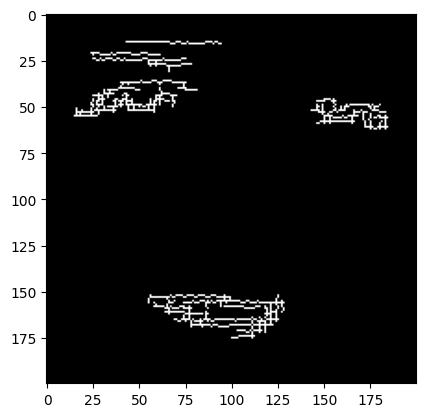

In [133]:
plt.imshow(edges_list_mixed[-3], cmap='gray')

In [134]:
for img in test_predictions_2:
    img[img > 0.5] = 1
    img[img <= 0.5] = 0

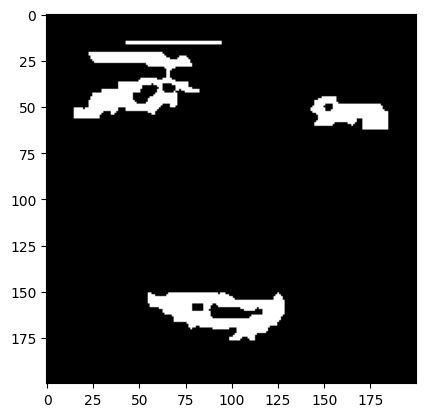

In [135]:
plt.imshow(test_predictions_2[-3], cmap='gray')

In [154]:
def calculate_error(y_true, y_pred, metric='mse'):
    """
    Calculate the error of prediction for a model with images (values in range 0-1).
    
    Parameters:
    - y_true: numpy array, ground truth images.
    - y_pred: numpy array, predicted images by the model.
    - metric: str, 'mse' for Mean Squared Error or 'mae' for Mean Absolute Error.
    
    Returns:
    - error: float, calculated error value.
    """
    # Ensure the inputs are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # Check shapes match
    if y_true.shape != y_pred.shape:
        raise ValueError("Shapes of y_true and y_pred must match.")
    
    # Clip values to [0, 1] to handle rounding/overflow issues
    y_true = np.clip(y_true, 0, 1)
    y_pred = np.clip(y_pred, 0, 1)
    
    if metric == 'mse':
        error = np.mean((y_true - y_pred) ** 2)
    elif metric == 'mae':
        error = np.mean(np.abs(y_true - y_pred))
    else:
        raise ValueError("Unsupported metric. Use 'mse' or 'mae'.")
    
    return error


In [155]:
train_pred = autoencoder_2.predict(edges_array_train)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step


In [156]:
errors_train_normal = calculate_error(train_pred, edges_array_train)

print(np.mean(errors_train_normal))

quantiles = np.quantile(errors_train_normal, [0.0, 0.25, 0.50, 0.75, .90, 1.0])
print(quantiles)

0.08123282
[0.08123282 0.08123282 0.08123282 0.08123282 0.08123282 0.08123282]


# CNN

In [21]:
# Define the CNN model
input_shape = (200, 200, 3)

model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

d:\Python\312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(train_features_mix, train_labels, epochs=20, batch_size=32, validation_data=(test_features_mix, test_labels))

# Evaluate the model
loss, accuracy = model.evaluate(test_features_mix, test_labels)
print(f'Test accuracy: {accuracy}')

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9585 - val_loss: 0.1877
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9585 - val_loss: 0.2099
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step - accuracy: 0.9991 - loss: 0.0025 - val_accuracy: 0.9627 - val_loss: 0.1862
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 1.0000 - loss: 5.1153e-04 - val_accuracy: 0.9627 - val_loss: 0.2099
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.9971 - loss: 0.0050 - val_accuracy: 0.9461 - val_loss: 0.2499
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.9968 - loss: 0.0136 - val_accuracy: 0.9585 - val_loss: 0.2855
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.9978 - loss: 0.0057 - val_accuracy: 0.9502 - val_loss: 0.2443
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.9924 - loss: 0.0321 - val_

In [157]:
# Define the CNN model
input_shape = (200, 200, 3)

modelito = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
modelito.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

d:\Python\312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = modelito.fit(train_features_mix, train_labels, epochs=20, batch_size=32, , validation_split=0.15, shuffle=True)

# Evaluate the model
loss, accuracy = modelito.evaluate(test_features_mix, test_labels)
print(f'Test accuracy: {accuracy}')

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.5106 - loss: 1.0752 - val_accuracy: 0.4979 - val_loss: 0.6900
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.5865 - loss: 0.6812 - val_accuracy: 0.7925 - val_loss: 0.5663
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.7878 - loss: 0.5148 - val_accuracy: 0.8755 - val_loss: 0.3305
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.8640 - loss: 0.3350 - val_accuracy: 0.8797 - val_loss: 0.2825
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.8360 - loss: 0.3984 - val_accuracy: 0.9004 - val_loss: 0.2457
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.8777 - loss: 0.2951 - val_accuracy: 0.8714 - val_loss: 0.2450
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.9008 - loss: 0.2417 - val_accuracy: 0.9129 - val_loss: 0.1805
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9271 - loss: 0.1949 - val_accu